# Parameter Estimation in the Passive 2 Compartment Neuronal Model #

Feb 10, 2023.


In [5]:
#set up
import numpy as np
import scipy.io as spio
from scipy.integrate import solve_ivp
##%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rcParams['font.size'] = 18
rc('font', family='sans-serif')
rcParams['font.family'] = 'Serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = False

In [6]:
# constants
Cm = 3.0    # Membrane Capcitance uF
gc = 1.85   # mS conductance take similar to traub model so that the resistance are in the order of Mohm 
gl = 0.1
tau = Cm/gl
pc = gc/gl #coupling/leak
p = 0.5 #fraction of cable length assigned to soma (1-p for dendrite)
Is = 1 # in uA/cm^2
Is_t = Is/p #Is tilde
# add Is_t, dependent on p

# Stimulus current function
def Istim(t):
    if t>20 and t<220:
        Istim = 2
    else:
        Istim=0
    return Istim

    
#2 compartment model ODEs
def TCO(t, y):
    Vs, Vd = y
    dVsdt = (-Vs + pc*(Vd - Vs) + Istim(t)/gl)/tau
    dVddt = (-Vd + pc*(Vs - Vd))/tau
    return [ dVsdt, dVddt ]


In [7]:
# initial values
Vs0 = 0 #mV
Vd0 = 0 #mV

# Solve TCO model
t_span = [0, 500]
sol = solve_ivp(TCO, t_span, [Vs0, Vd0])
print(sol)

# select timepoints
t_fe_step = 7 #arbitrary interval where the points are not too sparse or too clustered 
t_meas = [sol.t[i] for i in range(1, len(sol.t), t_fe_step)]
Vs_meas = [sol.y[0,i] for i in range(1, len(sol.t), t_fe_step)]
Vd_meas = [sol.y[1,i] for i in range(1, len(sol.t), t_fe_step)]


print("\n\n Measurements" )
print(" number of subintervals = {0:d}".format(len(sol.t)-1) )
print(" number of measurements = {0:d}".format(len(t_meas)) )

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-06 ...  4.988e+02  5.000e+02]
        y: [[ 0.000e+00  0.000e+00 ...  9.298e-04  8.925e-04]
            [ 0.000e+00  0.000e+00 ...  9.255e-04  8.915e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1550
     njev: 0
      nlu: 0


 Measurements
 number of subintervals = 209
 number of measurements = 30


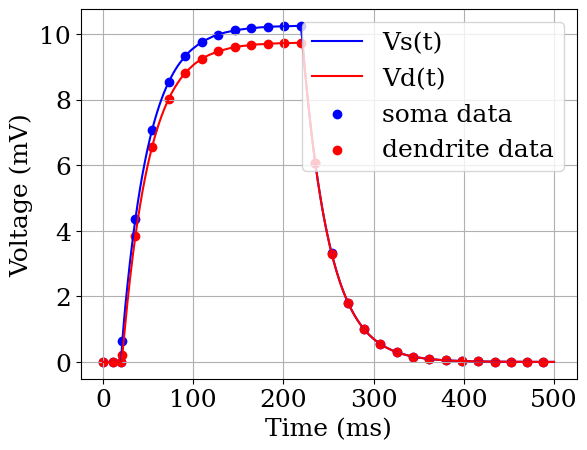

In [8]:
# Plot solution

plt.plot(sol.t, sol.y[0, :], 'b', label='Vs(t)')
plt.plot(sol.t, sol.y[1, :], 'r', label='Vd(t)')
plt.scatter(t_meas, Vs_meas, c='b', label='soma data')
plt.scatter(t_meas, Vd_meas, c='r', label='dendrite data')

plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
plt.grid()

#display(Vs_meas)
#display(Vd_meas)


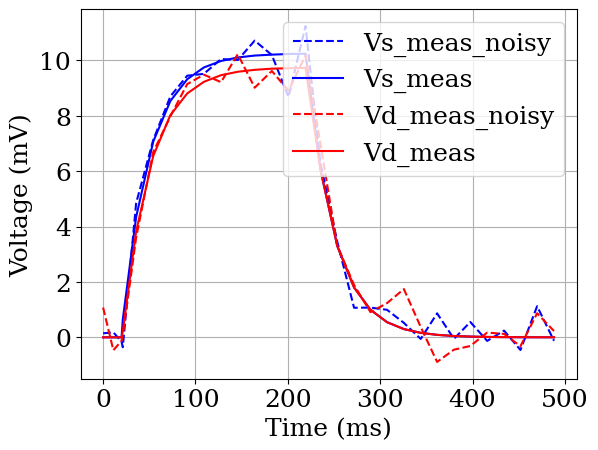

In [9]:
#add Gaussian noise
intervals = len(t_meas)
noise_Vs = np.random.normal(0, 0.5, intervals)
Vs_meas_noisy = np.add(Vs_meas, noise_Vs)
noise_Vd = np.random.normal(0, 0.5, intervals)
Vd_meas_noisy = np.add(Vd_meas, noise_Vd)

#display results
#showing how the gaussian noise data points compare to their true counterparts
plt.plot(t_meas, Vs_meas_noisy, linestyle='--', c='b', label='Vs_meas_noisy')
plt.plot(t_meas, Vs_meas, c='b', label='Vs_meas')
plt.plot(t_meas, Vd_meas_noisy, linestyle='--', c='r', label='Vd_meas_noisy')
plt.plot(t_meas, Vd_meas, c='r', label='Vd_meas')

plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
plt.grid()

## Parameter Estimation



In [10]:
#using pyomo for modeling
import pyomo.environ as pyo
import pyomo.dae as dae

# creating model 
model = pyo.ConcreteModel()

# time horizon
model.t = dae.ContinuousSet(bounds=(0,500), initialize=t_meas)  # include measurement times indiscretization

# time-dependent variables, why are those the bounds
model.Vs = pyo.Var(model.t, bounds=(-10,50))
model.dVs = dae.DerivativeVar(model.Vs, wrt = model.t)
model.Vd = pyo.Var(model.t, bounds=(-10,50))
model.dVd = dae.DerivativeVar(model.Vd, wrt = model.t)


# initial conditions
model.Vs[0].fix(0)
model.Vd[0].fix(0)


# parameters
model.tau = pyo.Var(domain=pyo.Reals, initialize=20, bounds=(0,40))   # ms time constant 
model.pc = pyo.Var(domain=pyo.Reals, initialize=7, bounds=(0,15))  # uF membrane capacitance 
model.gl = pyo.Var(domain=pyo.Reals, initialize=1.5, bounds=(0,5))

#time dependent parameter
def Istim_rule(model, t):
    if t>20 and t<220:
        return 2
    else:
        return 0.0

#parametrize the current, removed the second "model.t" which was unnecessary because only 1-D
model.Istim = pyo.Param(model.t, initialize=Istim_rule)

In [11]:
# ODE constraints
def TCP_Vs(m, t):
    if t == m.t.first():
        return pyo.Constraint.Skip  # Skip constraint at t=0
    Vs, Vd = (m.Vs[t], m.Vd[t])
    tau, pc, gl = (m.tau, m.pc, m.gl)
    dVsdt = (-Vs + pc*(Vd - Vs) + Istim(t)/gl)/tau

    return m.dVs[t]==dVsdt

def TCP_Vd(m, t):
    if t == m.t.first():
        return pyo.Constraint.Skip  # Skip constraint at t=0
    Vs, Vd = (m.Vs[t], m.Vd[t])
    tau, pc, gl = (m.tau, m.pc, m.gl)
    dVddt = (-Vd + pc*(Vs - Vd))/tau

    return m.dVd[t]==dVddt

# constraints
model.ode_Vs = pyo.Constraint(model.t, rule=TCP_Vs)
model.ode_Vd = pyo.Constraint(model.t, rule=TCP_Vd)

# # discretization
discretizer = pyo.TransformationFactory('dae.finite_difference')
discretizer.apply_to(model, nfe=3000, scheme='BACKWARD') 

In [12]:
# measurement indices
i_meas = np.zeros(len(t_meas), dtype=int)  
for k in range(len(t_meas)):
    i_meas[k] = model.t.find_nearest_index(t_meas[k])
    # print("t_meas={0:10.7f},  model.t={1:10.7f}".format(t_meas[k], model.t.at(i_meas[k]) ))   # check that measurement times are included in model.t
    # NOTE: model.t.find_nearest_index  returns indices based in 1-based indexing.
    #       Subtract 1 to get 0-based indexing.

# Objective function
def objective_rule(m):
    res = 0
    for (i,j) in enumerate(i_meas):
        res += (m.Vs[m.t.at(j)]-Vs_meas[i])**2     # Minimize difference in Vs
    return res

model.obj_fun_Vs = pyo.Objective(rule=objective_rule)




# initialize V_s
# perform the modeling given the noisy data
for (i,j) in enumerate(i_meas):
    if model.t.at(j) == 0: continue    # already have initial condition
    model.Vs[model.t.at(j)] = Vs_meas_noisy[i]
    model.Vd[model.t.at(j)] = Vd_meas_noisy[i]



model.display()

Model unknown

  Variables:
    Vs : Size=3001, Index=t
        Key                : Lower : Value                 : Upper : Fixed : Stale : Domain
                         0 :   -10 :                     0 :    50 :  True : False :  Reals
                     1e-06 :   -10 :   0.14563190433156015 :    50 : False : False :  Reals
                  0.173612 :   -10 :                  None :    50 : False :  True :  Reals
                  0.347223 :   -10 :                  None :    50 : False :  True :  Reals
                  0.520834 :   -10 :                  None :    50 : False :  True :  Reals
                  0.694446 :   -10 :                  None :    50 : False :  True :  Reals
                  0.868057 :   -10 :                  None :    50 : False :  True :  Reals
                  1.041668 :   -10 :                  None :    50 : False :  True :  Reals
                  1.215279 :   -10 :                  None :    50 : False :  True :  Reals
                   1.388

        Key                : Lower : Value : Upper : Fixed : Stale : Domain
                         0 :  None :  None :  None : False :  True :  Reals
                     1e-06 :  None :  None :  None : False :  True :  Reals
                  0.173612 :  None :  None :  None : False :  True :  Reals
                  0.347223 :  None :  None :  None : False :  True :  Reals
                  0.520834 :  None :  None :  None : False :  True :  Reals
                  0.694446 :  None :  None :  None : False :  True :  Reals
                  0.868057 :  None :  None :  None : False :  True :  Reals
                  1.041668 :  None :  None :  None : False :  True :  Reals
                  1.215279 :  None :  None :  None : False :  True :  Reals
                   1.38889 :  None :  None :  None : False :  True :  Reals
                  1.562501 :  None :  None :  None : False :  True :  Reals
                  1.736112 :  None :  None :  None : False :  True :  Reals
            

        Key                : Lower : Body : Upper
                     1e-06 :   0.0 : None :   0.0
                  0.173612 :   0.0 : None :   0.0
                  0.347223 :   0.0 : None :   0.0
                  0.520834 :   0.0 : None :   0.0
                  0.694446 :   0.0 : None :   0.0
                  0.868057 :   0.0 : None :   0.0
                  1.041668 :   0.0 : None :   0.0
                  1.215279 :   0.0 : None :   0.0
                   1.38889 :   0.0 : None :   0.0
                  1.562501 :   0.0 : None :   0.0
                  1.736112 :   0.0 : None :   0.0
                  1.909723 :   0.0 : None :   0.0
                  2.083334 :   0.0 : None :   0.0
                  2.256945 :   0.0 : None :   0.0
                  2.430556 :   0.0 : None :   0.0
                  2.604167 :   0.0 : None :   0.0
                  2.777778 :   0.0 : None :   0.0
                  2.951389 :   0.0 : None :   0.0
                     3.125 :   0.0 : None :   0.0


In [13]:
# Solve
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model, tee=True) 

Ipopt 3.14.11: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    49353
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    23716

Total number of variables............................:    12003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     6003
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number



True parameters:
 tau = 3.0000e+01 
 pc = 1.8500e+01 
 gl = 1.0000e-01
Computed parameters:
 tau = 3.0335e+01 
 pc = 1.5000e+01 
 gl = 1.0048e-01


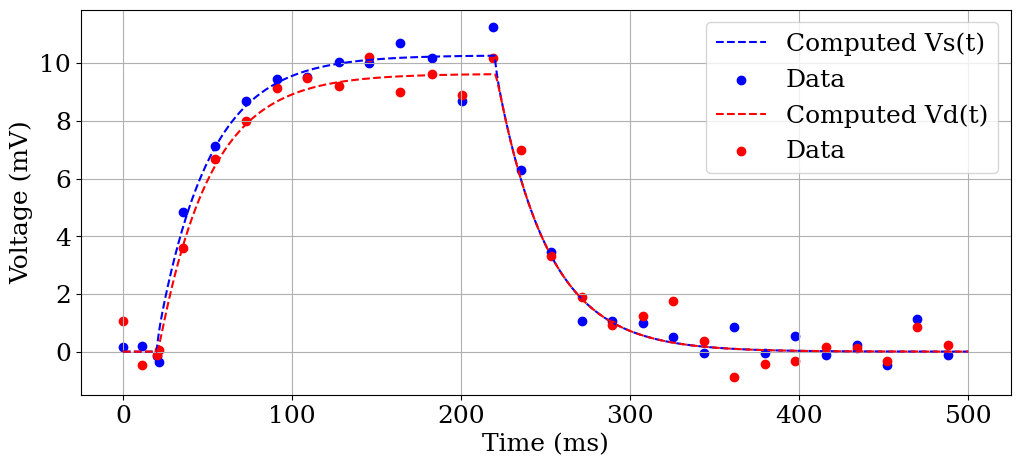

In [14]:
# print optimal solution
print("\n")
print("True parameters:")
print(" tau = {0:10.4e} \n pc = {1:10.4e} \n gl = {2:10.4e}".format(tau, pc, gl))
print("Computed parameters:")
print(" tau = {0:10.4e} \n pc = {1:10.4e} \n gl = {2:10.4e}".format(model.tau(), model.pc(), model.gl()))

#simulates the soluations generated by pyomo
t_sim = [t for t in model.t]
Vs_sim = [model.Vs[t]() for t in model.t]
Vd_sim = [model.Vd[t]() for t in model.t]

# plot the solution generated by pyomo alongside the noisy data
fig1 = plt.figure(figsize=(12,5))
plt.plot(t_sim, Vs_sim, 'b--', label='Computed Vs(t)')
plt.scatter(t_meas, Vs_meas_noisy, c='b', label='Data')
plt.plot(t_sim, Vd_sim, 'r--', label='Computed Vd(t)')
plt.scatter(t_meas, Vd_meas_noisy, c='r', label='Data')

#add labels
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper right')
plt.grid()


